# Probar la extracción de datos y análisis para la API de BingX

In [1]:
import os
import requests
import datetime
import numpy as np
import pandas as pd
import seaborn as sns

interval | field description
---------|-----------------
1m | One-minute K line
3m | Three-minute K line
5m | Five-minute K line
15m | 15 minutes K line
30m | Thirty minutes K line
1h | One-hour candlestick line
2h | Two-hour K-line
4h | Four-hour K line
6h | Six-hour K line
8h | Eight-hour K-line
12h | 12-hour K line
1d | 1 day candlestick
3d | 3-day K-line
1w | Weekly K-line
1M | Monthly candlestick

# 1) Data Minning

In [2]:
def past_timestamp(cantidad, periodo):
    "Devuelve en milisegundos el timestamp de hace 'cantidad' 'periodo'"
    if periodo == "min":
        delta = datetime.timedelta(minutes=cantidad)
    elif periodo == "hour":
        delta = datetime.timedelta(hours=cantidad)
    elif periodo == "days":
        delta = datetime.timedelta(days=cantidad)
    else:
        raise ValueError("Período inválido")
    
    now = datetime.datetime.now()
    past = now - delta
    timestamp = datetime.datetime.timestamp(past)
    return timestamp * 1000

def now_timestamp():
    "devuelve en milisegundos el timestamp actual"
    return datetime.datetime.timestamp(datetime.datetime.now()) * 1000

def response_to_dataframe(response):
    data = response['data']
    df = pd.DataFrame(data)
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df[['open', 'close', 'high', 'low', 'volume']] = df[['open', 'close', 'high', 'low', 'volume']].astype(float)
    return df

def guardar_csv(path_output, data):
    """
    Guarda un DataFrame como archivo CSV en la ruta especificada.

    Argumentos:
    - path_output: ruta relativa o absoluta donde se guardará el archivo CSV.
    - data: DataFrame a guardar como archivo CSV.

    """
    # Obtener el path absoluto del archivo de salida
    path_absoluto_output = os.path.abspath(path_output)
    print('Guardando en ubicación:')
    print(path_absoluto_output)
    # Abrir el archivo de salida
    with open(path_absoluto_output, 'w') as archivo_output:
        # Guardar el archivo csv
        data.to_csv(archivo_output, index=False)

def crear_directorio(path_output):
    """
    Crea un directorio en la ruta especificada si este no existe. Si el directorio ya existe, se muestra un mensaje indicando
    la ubicación del directorio existente.

    Argumentos:
    - path_output: ruta relativa o absoluta donde se creará el directorio.

    """
    path_absoluto_output = os.path.abspath(path_output)
    if not os.path.exists(path_absoluto_output):
        print(f'Se crea el directorio {path_output} en ubicación:')
        print(path_absoluto_output)
        os.makedirs(path_absoluto_output)
    else:
        print(f'Directorio {path_absoluto_output} ya existe')


In [3]:
URL = 'https://open-api.bingx.com'
path = '/openApi/swap/v2/quote/klines'
method = 'GET'

service = URL + path

symbol = 'BTC-USDT'
interval = '15m'
limit = 1440  #default 500, max 1440

startTime = int(past_timestamp(1400*15, 'min'))
endTime = int(now_timestamp())

if False:
    response = requests.request(method, service, params={'symbol':symbol, 'interval':interval, 'limit':limit, 'startTime':startTime, 'endTime':endTime})
    df = response_to_dataframe(response.json())
    fecha_actual = datetime.datetime.now()
    crear_directorio('data')
    nombre_archivo = "{}_{}_{}.csv".format(symbol, interval, fecha_actual.strftime('%Y-%m-%d_%H-%M-%S'))
    guardar_csv('data/{}'.format(nombre_archivo), df)
    with open('last_file.txt', 'w') as f:
        f.write(nombre_archivo)


else:
    with open('last_file.txt', 'r') as f:
        nombre_archivo = f.read()
    df = pd.read_csv('data/{}'.format(nombre_archivo))


In [4]:
df

,open,close,high,low,volume,time
0,30388.5,30386.0,30400.0,30372.0,124.22,2023-04-15 02:15:00
1,30386.0,30386.2,30399.5,30344.5,183.56,2023-04-15 02:30:00
2,30386.2,30378.0,30406.5,30378.0,100.04,2023-04-15 02:45:00
3,30378.0,30389.0,30420.5,30375.5,166.78,2023-04-15 03:00:00
4,30389.0,30386.0,30405.0,30382.5,124.14,2023-04-15 03:15:00
...,...,...,...,...,...,...
1394,29346.0,29331.5,29351.0,29321.0,158.80,2023-04-29 14:45:00
1395,29331.5,29308.0,29332.0,29308.0,148.35,2023-04-29 15:00:00
1396,29308.5,29330.0,29338.0,29308.0,135.06,2023-04-29 15:15:00
1397,29330.0,29332.0,29333.0,29314.5,140.54,2023-04-29 15:30:00


# 2) Look-Ahead Bias

In [5]:
# cruce de SMAs
def cruce_sma_fast_slow(data, fast, slow):
    dataux = pd.DataFrame()
    dataux[f"SMA_{fast}"] = data.loc[:, "close"].rolling(fast).mean()
    dataux[f"SMA_{slow}"] = data.loc[:, "close"].rolling(slow).mean()
    data.loc[:, f"Cruce_{fast}_{slow}"] = (
        dataux.loc[:, f"SMA_{fast}"] / dataux.loc[:, f"SMA_{slow}"] * 100 - 100
    )
    return data

# calculo rsi
def rsi(data, ruedas):
    dataux = pd.DataFrame()
    dataux["dif"] = data['close'].diff()
    dataux["win"] = np.where(dataux["dif"] > 0, dataux["dif"], 0)
    dataux["loss"] = np.where(dataux["dif"] < 0, abs(dataux["dif"]), 0)
    dataux["ema_win"] = dataux.win.ewm(alpha=1 / ruedas).mean()
    dataux["ema_loss"] = dataux.loss.ewm(alpha=1 / ruedas).mean()
    dataux["rs"] = dataux.ema_win / dataux.ema_loss
    data.loc[:, "rsi"] = 100 - (100 / (1 + dataux.loc[:, "rs"]))
    return data

# Calculo volatilidad
def volatilidad(data, sigma):
    data.loc[:, "variacion"] = data.loc[:, "close"].pct_change() * 100
    data.loc[:, f"sigma_{sigma}"] = data.loc[:, "variacion"].rolling(sigma).std() * (
        sigma**0.5
    )
    return data

def forward(data, fw):
    for step in fw:
        data[f"fw_{step}"] = (data['close'].shift(-step) / data['close'].shift() - 1) * 100
    return data

def ajustar_datos(data, features):
    data = data.iloc[:, 3:].dropna()
    data.loc[:, features] = data.loc[:, features].shift()
    return data.round(4)

In [6]:
# PARAMETROS INCIALES
ruedas = 14
fast, slow = 20, 60
sigma = 40

fw = 10, 20

features = [f"Cruce_{fast}_{slow}", "rsi", f"sigma_{sigma}"]  # atributo dinámico
forwards = [f"fw_{i}" for i in fw]  # atributo preseteado, dinámico

df_1 = df.copy()
df_1 = cruce_sma_fast_slow(df, fast, slow)
df_1 = rsi(df, ruedas)
df_1 = volatilidad(df, sigma)
df_1 = forward(df, fw)
df_1 = ajustar_datos(df, features)

df_1

,low,volume,time,Cruce_20_60,rsi,variacion,sigma_40,fw_10,fw_20
59,30266.0,246.28,2023-04-15 17:00:00,NaN,NaN,-0.0973,NaN,-0.2012,0.0000
60,30220.0,285.06,2023-04-15 17:15:00,-0.0848,37.0193,-0.0578,0.5208,0.1337,0.1684
61,30202.0,337.02,2023-04-15 17:30:00,-0.0984,34.8434,-0.0793,0.5135,0.1586,0.2693
62,30205.0,200.27,2023-04-15 17:45:00,-0.1188,32.0602,-0.0116,0.5165,0.2447,0.3422
63,30240.5,149.01,2023-04-15 18:00:00,-0.1410,31.6630,0.0645,0.5128,0.2364,0.3174
...,...,...,...,...,...,...,...,...,...
1374,29276.0,107.85,2023-04-29 09:45:00,-0.0003,41.5519,0.0632,0.5110,0.0905,0.1879
1375,29283.5,138.41,2023-04-29 10:00:00,-0.0162,45.5019,-0.0358,0.5126,0.0171,0.0444
1376,29245.0,145.29,2023-04-29 10:15:00,-0.0334,43.6969,-0.0734,0.5134,-0.0222,0.1554
1377,29238.0,99.63,2023-04-29 10:30:00,-0.0497,40.1820,0.0051,0.5184,0.1162,0.2358


In [7]:
data = df_1

for feature in features:
    r2 = data[feature].corr(data.variacion)
    print(f"El r2 con {feature} es {r2:.2f}")

data.corr().loc[["variacion"] + forwards, features].round(2)

El r2 con Cruce_20_60 es -0.04
El r2 con rsi es 0.02
El r2 con sigma_40 es 0.01


C:\Users\Agustin\AppData\Local\Temp\ipykernel_2604\440579976.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr().loc[["variacion"] + forwards, features].round(2)


,Cruce_20_60,rsi,sigma_40
variacion,-0.04,0.02,0.01
fw_10,-0.11,0.05,0.03
fw_20,-0.08,0.02,0.00


In [8]:
df["variacion_tipo"] = np.where(df.variacion > 0, "Up", "Down")

medias = df.groupby("variacion_tipo").mean().loc[:, features].round(2)
desvios = df.groupby("variacion_tipo").std().loc[:, features].round(2)

print(f"Medias según clasificación \n{medias}\n")
print(f"Desvíos según clasificación \n{desvios}\n")

Medias según clasificación 
                Cruce_20_60    rsi  sigma_40
variacion_tipo                              
Down                  -0.05  46.31      1.47
Up                    -0.06  52.24      1.48

Desvíos según clasificación 
                Cruce_20_60    rsi  sigma_40
variacion_tipo                              
Down                   0.74  11.60      0.95
Up                     0.75  11.78      0.94



C:\Users\Agustin\AppData\Local\Temp\ipykernel_2604\2174588580.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  medias = df.groupby("variacion_tipo").mean().loc[:, features].round(2)
C:\Users\Agustin\AppData\Local\Temp\ipykernel_2604\2174588580.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  desvios = df.groupby("variacion_tipo").std().loc[:, features].round(2)


[(-5.0, 5.0)]

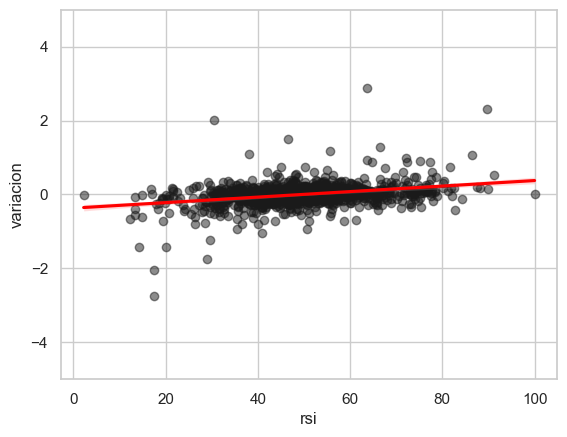

In [9]:
sns.set(style="whitegrid")
g = sns.regplot(
    x="rsi",
    y="variacion",
    data=df,
    line_kws={"color": "red"},
    scatter_kws={"color": "k", "alpha": 0.5},
)

g.set(ylim=(-5, 5))

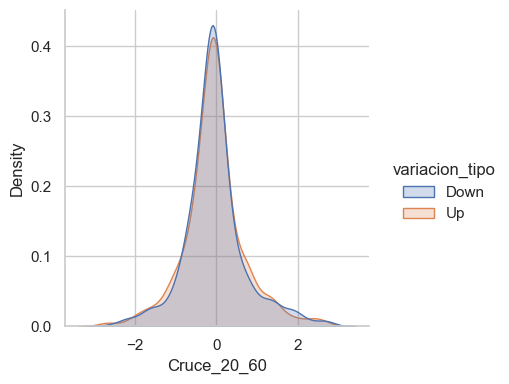

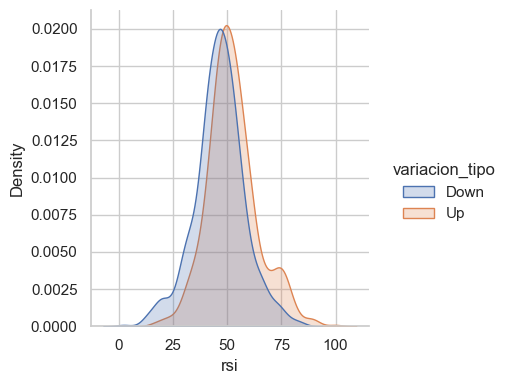

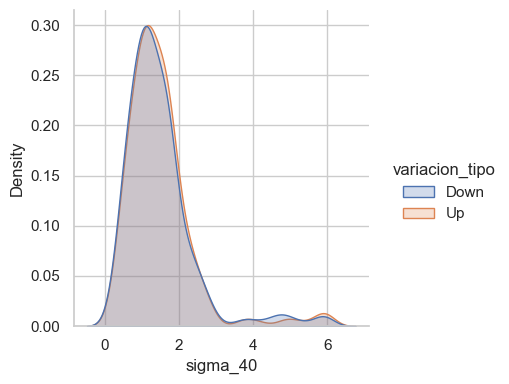

In [10]:
for feature in features:
    sns.displot(df, x=feature, hue="variacion_tipo", kind="kde", height=4, fill=True)

# 3) Squeez Momentum Indicator

In [13]:
df

,open,close,high,low,volume,time,Cruce_20_60,rsi,variacion,sigma_40,fw_10,fw_20,variacion_tipo
0,30388.5,30386.0,30400.0,30372.0,124.22,2023-04-15 02:15:00,NaN,NaN,NaN,NaN,NaN,NaN,Down
1,30386.0,30386.2,30399.5,30344.5,183.56,2023-04-15 02:30:00,NaN,100.000000,0.000658,NaN,0.027973,0.105312,Up
2,30386.2,30378.0,30406.5,30378.0,100.04,2023-04-15 02:45:00,NaN,2.214651,-0.026986,NaN,0.045415,0.150726,Down
3,30378.0,30389.0,30420.5,30375.5,166.78,2023-04-15 03:00:00,NaN,59.469882,0.036210,NaN,0.093818,0.131674,Up
4,30389.0,30386.0,30405.0,30382.5,124.14,2023-04-15 03:15:00,NaN,50.743486,-0.009872,NaN,0.116819,0.092139,Down
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394,29346.0,29331.5,29351.0,29321.0,158.80,2023-04-29 14:45:00,-0.038116,52.416816,-0.049410,0.484268,NaN,NaN,Down
1395,29331.5,29308.0,29332.0,29308.0,148.35,2023-04-29 15:00:00,-0.034477,47.851107,-0.080119,0.472530,NaN,NaN,Down
1396,29308.5,29330.0,29338.0,29308.0,135.06,2023-04-29 15:15:00,-0.024614,52.060955,0.075065,0.467781,NaN,NaN,Up
1397,29330.0,29332.0,29333.0,29314.5,140.54,2023-04-29 15:30:00,-0.015007,52.436865,0.006819,0.466175,NaN,NaN,Up


In [14]:
# Nota: Este código puede requerir algunas adaptaciones según la estructura de tus datos. 
#Asumimos que los datos están almacenados en un archivo CSV con una columna llamada 'date' como índice y las columnas 'close', 'high', 'low' y 'tr'.


import ta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Inputs
length = 20
mult = 2.0
lengthKC = 20
multKC = 1.5
useTrueRange = True

# Load data (assuming 'close', 'high', 'low', and 'tr' columns are available)
df.set_index('time', inplace=True)

# Calculate BB
basis = ta.sma(df['close'], length=length)
dev = multKC * ta.stdev(df['close'], length=length)
upperBB = basis + dev
lowerBB = basis - dev

# Calculate KC
ma = ta.sma(df['close'], length=lengthKC)
range = ta.true_range(df['high'], df['low'], df['close']) if useTrueRange else (df['high'] - df['low'])
rangema = ta.sma(range, length=lengthKC)
upperKC = ma + rangema * multKC
lowerKC = ma - rangema * multKC

sqzOn = (lowerBB > lowerKC) & (upperBB < upperKC)
sqzOff = (lowerBB < lowerKC) & (upperBB > upperKC)
noSqz = (~sqzOn) & (~sqzOff)

val = ta.linreg(df['close'] - ta.avg([ta.highest(df['high'], length=lengthKC), ta.lowest(df['low'], length=lengthKC), ta.sma(df['close'], length=lengthKC)]), length=lengthKC)

bcolor = np.where(val > 0, np.where(val > val.shift(1), 'lime', 'green'), np.where(val < val.shift(1), 'red', 'maroon'))
scolor = np.where(noSqz, 'blue', np.where(sqzOn, 'black', 'gray'))

plt.plot(val, color=bcolor, linestyle='-', linewidth=4)
plt.plot(np.zeros_like(val), color=scolor, marker='x', linestyle='-', linewidth=2)
plt.show()




AttributeError: module 'ta' has no attribute 'sma'